In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import calendar
import locale

# locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252') #(Windows)
locale.setlocale(locale.LC_TIME, "es_PE.UTF-8")  # (Linux)

'es_PE.UTF-8'

In [2]:
Archivo_Ruta = r"Base_datos_SIDPOL_diciembre_2025.xlsx"
df_SIDPOL = pd.read_excel(Archivo_Ruta, sheet_name="Temp4")
df_SIDPOL.head()

,ANIO,MES,DPTO_HECHO_NEW,PMODALIDADES,n_dist_ID_DGC
0,2018,1,AMAZONAS,Estafa,8
1,2018,1,AMAZONAS,Extorsión,2
2,2018,1,AMAZONAS,Homicidio,1
3,2018,1,AMAZONAS,Hurto,148
4,2018,1,AMAZONAS,Otros,229


In [3]:
df_SIDPOL.info()
df_SIDPOL.dtypes

<class 'pandas.DataFrame'>
RangeIndex: 20068 entries, 0 to 20067
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ANIO            20068 non-null  int64
 1   MES             20068 non-null  int64
 2   DPTO_HECHO_NEW  20068 non-null  str  
 3   PMODALIDADES    20068 non-null  str  
 4   n_dist_ID_DGC   20068 non-null  int64
dtypes: int64(3), str(2)
memory usage: 784.0 KB


ANIO              int64
MES               int64
DPTO_HECHO_NEW      str
PMODALIDADES        str
n_dist_ID_DGC     int64
dtype: object

In [4]:
# Agregar la columna NOMBRE_MES en base a la columna MES
df_SIDPOL["NOMBRE_MES"] = df_SIDPOL["MES"].apply(
    lambda x: calendar.month_name[x].capitalize()
)
# Eliminar la columna MES
df_SIDPOL = df_SIDPOL.drop(columns=["MES"])
# Ordenar las columnas
orden_columnas = [
    "ANIO",
    "NOMBRE_MES",
    "DPTO_HECHO_NEW",
    "PMODALIDADES",
    "n_dist_ID_DGC",
]
df_SIDPOL = df_SIDPOL[orden_columnas]
# cambiar el nombre de la columnas
df_SIDPOL.rename(
    columns={
        "ANIO": "AÑO",
        "DPTO_HECHO_NEW": "REGIÓN",
        "PMODALIDADES": "MODALIDAD",
        "n_dist_ID_DGC": "CANTIDAD",
    },
    inplace=True,
)
df_SIDPOL.head()


,AÑO,NOMBRE_MES,REGIÓN,MODALIDAD,CANTIDAD
0,2018,Enero,AMAZONAS,Estafa,8
1,2018,Enero,AMAZONAS,Extorsión,2
2,2018,Enero,AMAZONAS,Homicidio,1
3,2018,Enero,AMAZONAS,Hurto,148
4,2018,Enero,AMAZONAS,Otros,229


In [5]:
TABLA_POR_MODALIDAD = pd.pivot_table(
    df_SIDPOL, index="MODALIDAD", columns="AÑO", values="CANTIDAD", aggfunc="sum"
)

TABLA_POR_MODALIDAD.loc["TOTAL"] = TABLA_POR_MODALIDAD.sum(axis=0)

TABLA_POR_MODALIDAD.style.set_table_attributes("style='width: auto;'")

AÑO,2018,2019,2020,2021,2022,2023,2024,2025
MODALIDAD,,,,,,,,
Corrupción,117,175,256,233,268,264,326,292
Estafa,9557,12172,14028,20689,26782,34092,39912,38173
Extorsión,3225,3865,2837,4735,16346,22675,22361,26585
Homicidio,1076,1114,1168,1577,1883,2336,2568,2672
Hurto,162381,166718,104129,134201,171479,232398,221575,174400
Otros,128988,146193,131081,159853,198819,212898,225693,217535
Robo,103135,102524,51858,66223,90047,150397,112574,62844
Secuestro,1446,1700,1114,1378,1838,1802,1685,1587
Violación de la libertad sexual,19974,25010,22314,24489,26637,27310,26641,22856


In [6]:
# filtrar los datos de Setiembre a Diciembre
filtro_4_meses = df_SIDPOL[
    df_SIDPOL["NOMBRE_MES"].isin(["Setiembre", "Octubre", "Noviembre", "Diciembre"])
]


In [7]:
TABLA_SEP_DIC = pd.pivot_table(
    filtro_4_meses, index="MODALIDAD", columns="AÑO", values="CANTIDAD", aggfunc="sum"
)


TABLA_SEP_DIC.loc["TOTAL"] = TABLA_SEP_DIC.sum(axis=0)
TABLA_SEP_DIC.style.set_table_attributes("style='width: auto;'")

AÑO,2018,2019,2020,2021,2022,2023,2024,2025
MODALIDAD,,,,,,,,
Corrupción,43,51,122,72,89,81,122,95
Estafa,3407,4400,5847,7686,9187,12528,12930,12522
Extorsión,1240,1468,1099,2137,7025,8549,8128,7797
Homicidio,378,404,421,535,730,839,908,795
Hurto,57275,57307,37038,50170,61751,83655,66727,55965
Otros,42892,50204,47854,58642,63677,67419,71708,63066
Robo,36995,35077,16802,25712,34319,52748,29193,19780
Secuestro,555,669,423,527,632,600,583,501
Violación de la libertad sexual,7489,8988,8262,8438,8797,9312,9359,7020


In [8]:
def tabla_y_grafico_region(
    modalidad, anio1, anio2, mostrar=True, retornar_buffer=False
):
    # --- 1. PROCESAMIENTO DE DATOS ---
    # Filtrar datos según modalidad y años
    filtro_año_mes = df_SIDPOL[
        (df_SIDPOL["AÑO"].isin([anio1, anio2])) & (df_SIDPOL["MODALIDAD"] == modalidad)
    ]

    # Crear tabla pivote con suma por región y año
    TABLA_POR_REGION = (
        pd.pivot_table(
            filtro_año_mes,
            index="REGIÓN",
            columns="AÑO",
            values="CANTIDAD",
            aggfunc="sum",
        )
        .fillna(0)
        .sort_values(by=anio2, ascending=False)
    )

    # Agregar fila total general
    TABLA_POR_REGION.loc["TOTAL GENERAL"] = TABLA_POR_REGION.sum(numeric_only=True)

    # Calcular variación porcentual
    TABLA_POR_REGION["VARIACIÓN %"] = (
        (TABLA_POR_REGION[anio2] / TABLA_POR_REGION[anio1]) - 1
    ) * 100

    TABLA_POR_REGION["VARIACIÓN %"] = (
        TABLA_POR_REGION["VARIACIÓN %"].replace([np.inf, -np.inf], 0).fillna(0).round(2)
    )

    # Resetear índice para que REGIÓN sea columna
    TABLA_POR_REGION = TABLA_POR_REGION.reset_index()

    # --- 2. MOSTRAR TABLA EN EL NOTEBOOK ---
    print(f"Denuncias por {modalidad.upper()} a nivel regional: {anio1}-{anio2}")
    display(TABLA_POR_REGION)

    TABLA_POR_REGION2 = TABLA_POR_REGION.copy()

    # Eliminar "TOTAL GENERAL" para el gráfico
    TABLA_POR_REGION2 = TABLA_POR_REGION2[
        TABLA_POR_REGION2["REGIÓN"] != "TOTAL GENERAL"
    ]
    # Crear columna para color según aumento o disminución
    TABLA_POR_REGION2["COLOR"] = TABLA_POR_REGION2["VARIACIÓN %"].apply(
        lambda x: "Aumento" if x > 0 else "Disminuyó"
    )
    # Ordenar tabla por variación
    TABLA_POR_REGION2 = TABLA_POR_REGION2.sort_values(by="VARIACIÓN %", ascending=True)
    orden_regiones = TABLA_POR_REGION2["REGIÓN"].tolist()

    plt.ioff()

    # --- 3. CREAR EL GRÁFICO ---
    fig, ax = plt.subplots(figsize=(10, len(orden_regiones) * 0.4 + 2))
    ax = sns.barplot(
        data=TABLA_POR_REGION2,
        y="REGIÓN",
        x="VARIACIÓN %",
        hue="COLOR",
        palette={"Aumento": "steelblue", "Disminuyó": "salmon"},
        order=orden_regiones,
        ax=ax,
    )

    # Añadir etiquetas de variación al final de cada barra
    for _, row in TABLA_POR_REGION2.iterrows():
        x = row["VARIACIÓN %"]
        y = orden_regiones.index(row["REGIÓN"])
        ax.text(
            x + (1 if x > 0 else -1),
            y,
            f"{x:.2f}%",
            va="center",
            ha="left" if x > 0 else "right",
            color="black",
            fontsize=9,
        )

    # Añadir etiquetas con nombre de región
    for _, row in TABLA_POR_REGION2.iterrows():
        x = row["VARIACIÓN %"]
        y = orden_regiones.index(row["REGIÓN"])
        if x <= 0:
            xpos = 1.5
            halign = "left"
        else:
            xpos = -1.5
            halign = "right"
        ax.text(
            xpos,
            y,
            row["REGIÓN"],
            va="center",
            ha=halign,
            fontsize=9,
            fontweight="bold",
            color="dimgray",
        )

    ax.margins(x=0.2, y=0.02)
    ax.axvline(0, color="black", linestyle="--")
    ax.set_title(
        f"Variación porcentual en denuncias por {modalidad.upper()} a nivel regional: \n ({anio1}–{anio2})"
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis="y", length=0)
    sns.despine(left=True, bottom=True)
    ax.legend(
        title="", bbox_to_anchor=(0.5, -0.02), loc="upper center", frameon=False, ncol=2
    )

    # --- 4. GENERAR BUFFER PARA EXCEL ---
    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight", dpi=100)
    img_buffer.seek(0)

    # --- 5. MOSTRAR EL GRÁFICO EN EL NOTEBOOK ---
    plt.show()

    # Limpiar y resetear
    plt.close(fig)
    plt.ion()

    # --- 6. RETORNO ---
    # Solo retornamos la tabla y el buffer
    return TABLA_POR_REGION, img_buffer

In [9]:
list(df_SIDPOL["MODALIDAD"].unique())

['Estafa',
 'Extorsión',
 'Homicidio',
 'Hurto',
 'Otros',
 'Robo',
 'Violación de la libertad sexual',
 'Corrupción',
 'Secuestro']

Denuncias por CORRUPCIÓN a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,74.0,69.0,-6.76
1,CUSCO,19.0,26.0,36.84
2,AREQUIPA,13.0,21.0,61.54
3,JUNIN,23.0,20.0,-13.04
4,PIURA,19.0,18.0,-5.26
5,ANCASH,32.0,16.0,-50.00
6,REGION LIMA,9.0,13.0,44.44
7,HUANUCO,10.0,13.0,30.00
8,LA LIBERTAD,8.0,13.0,62.50
9,CAJAMARCA,8.0,11.0,37.50


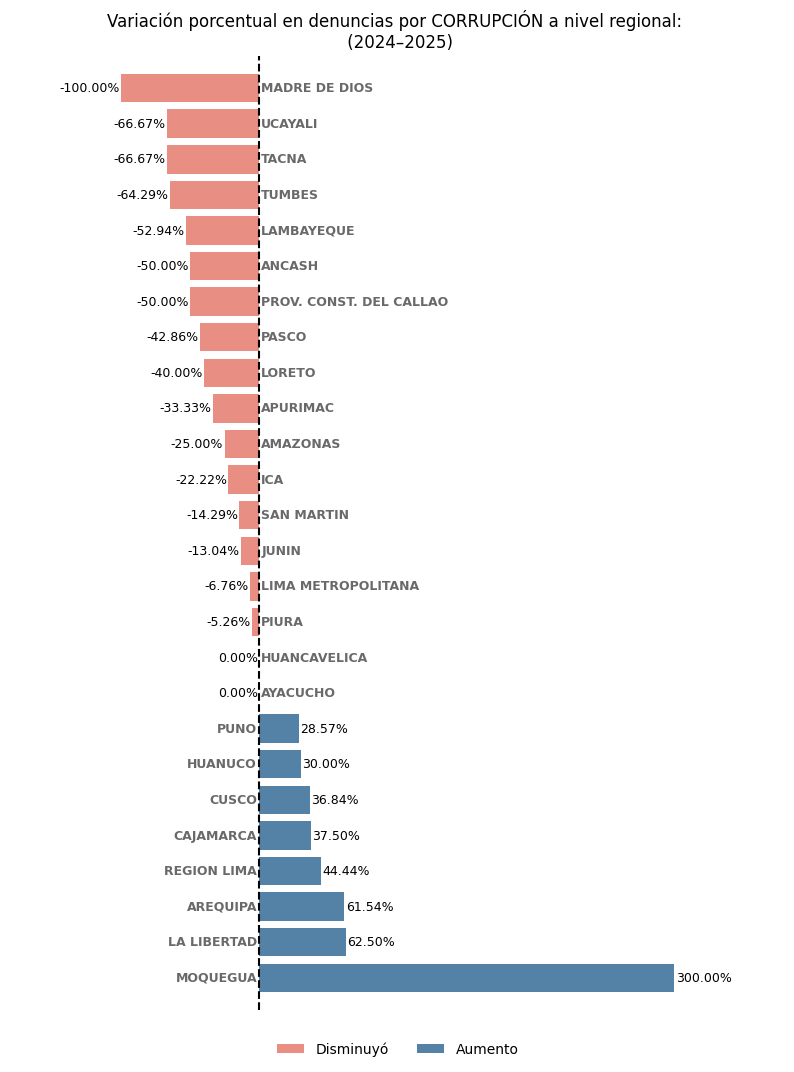

In [10]:
tabla_corrupcion, img_corrupcion = tabla_y_grafico_region("Corrupción", 2024, 2025)

Denuncias por ESTAFA a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,15997,16468,2.94
1,AREQUIPA,2607,2306,-11.55
2,LA LIBERTAD,2288,2157,-5.73
3,LAMBAYEQUE,2201,2132,-3.13
4,PIURA,1902,1610,-15.35
5,ICA,1550,1592,2.71
6,CUSCO,1492,1314,-11.93
7,PROV. CONST. DEL CALLAO,1348,1154,-14.39
8,REGION LIMA,1199,1032,-13.93
9,JUNIN,1138,980,-13.88


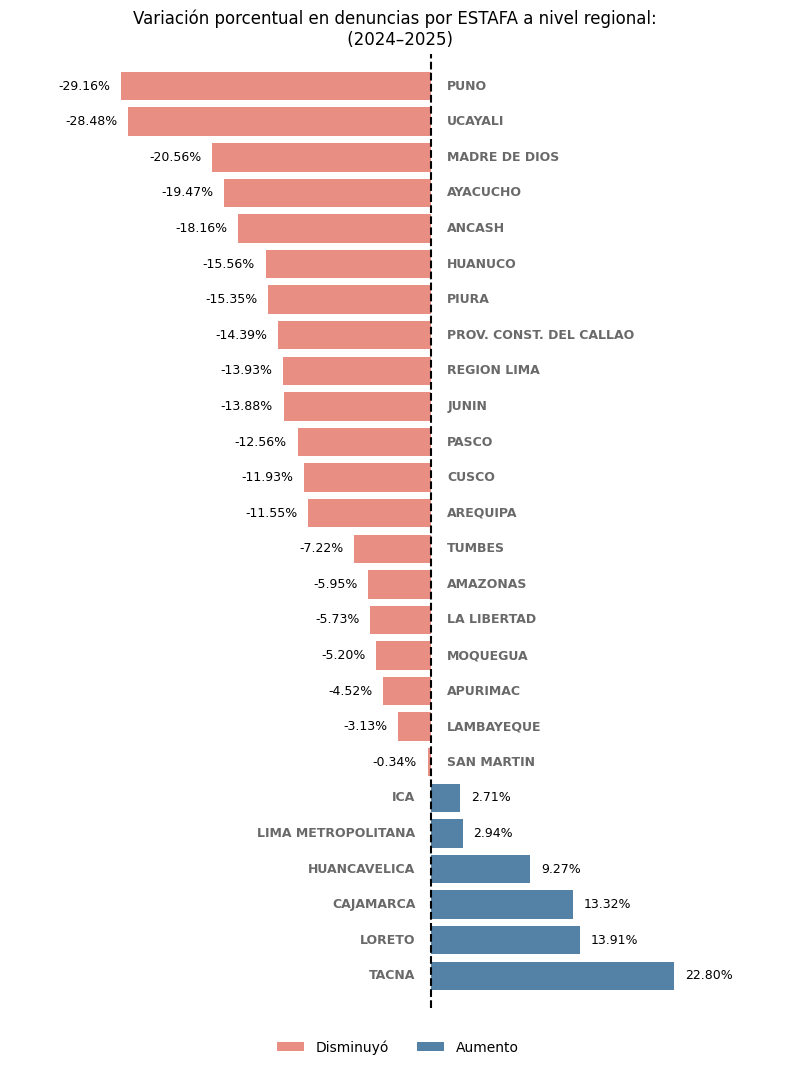

In [11]:
tabla_estafa, img_estafa = tabla_y_grafico_region("Estafa", 2024, 2025)

Denuncias por EXTORSIÓN a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,8131,11192,37.65
1,LA LIBERTAD,5141,4400,-14.41
2,PIURA,2204,2842,28.95
3,REGION LIMA,1224,1361,11.19
4,LAMBAYEQUE,867,972,12.11
5,PROV. CONST. DEL CALLAO,641,935,45.87
6,ANCASH,607,762,25.54
7,ICA,598,751,25.59
8,TUMBES,313,596,90.42
9,AREQUIPA,410,493,20.24


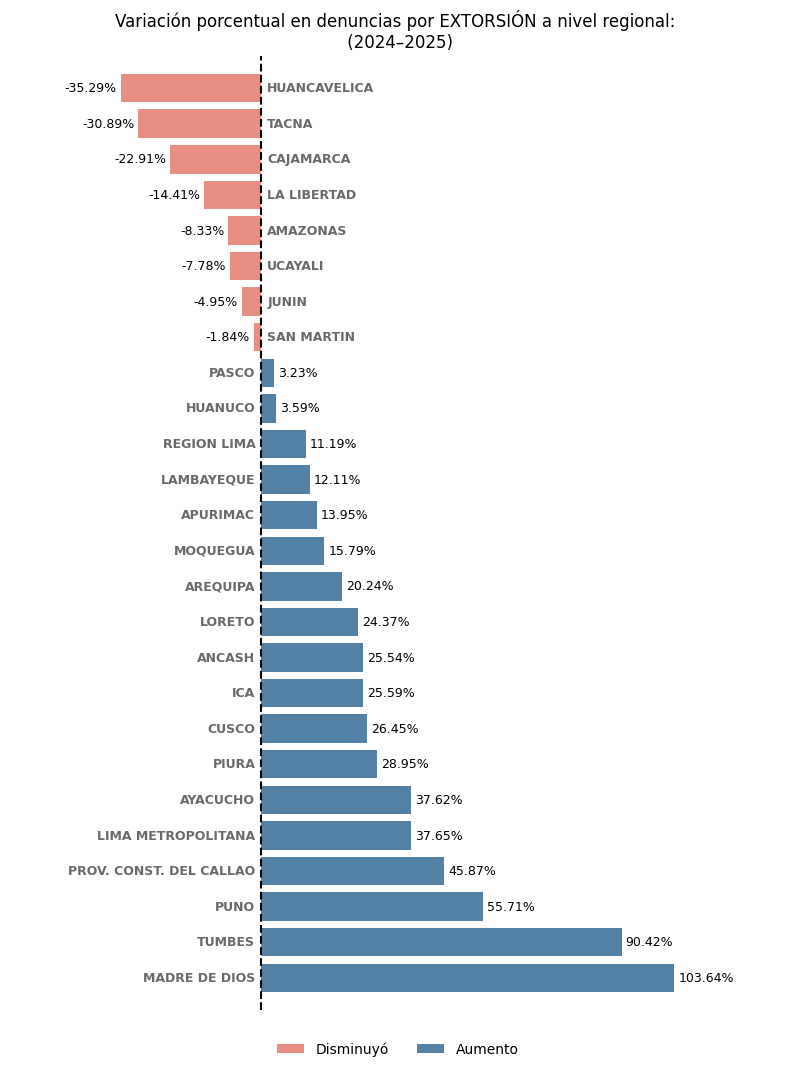

In [12]:
tabla_extorsion, img_extorsion = tabla_y_grafico_region("Extorsión", 2024, 2025)

Denuncias por HOMICIDIO a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,1022,994,-2.74
1,PROV. CONST. DEL CALLAO,221,280,26.70
2,LA LIBERTAD,239,238,-0.42
3,REGION LIMA,113,162,43.36
4,PIURA,134,109,-18.66
5,ICA,103,95,-7.77
6,AREQUIPA,59,85,44.07
7,PUNO,59,84,42.37
8,CUSCO,65,63,-3.08
9,JUNIN,59,63,6.78


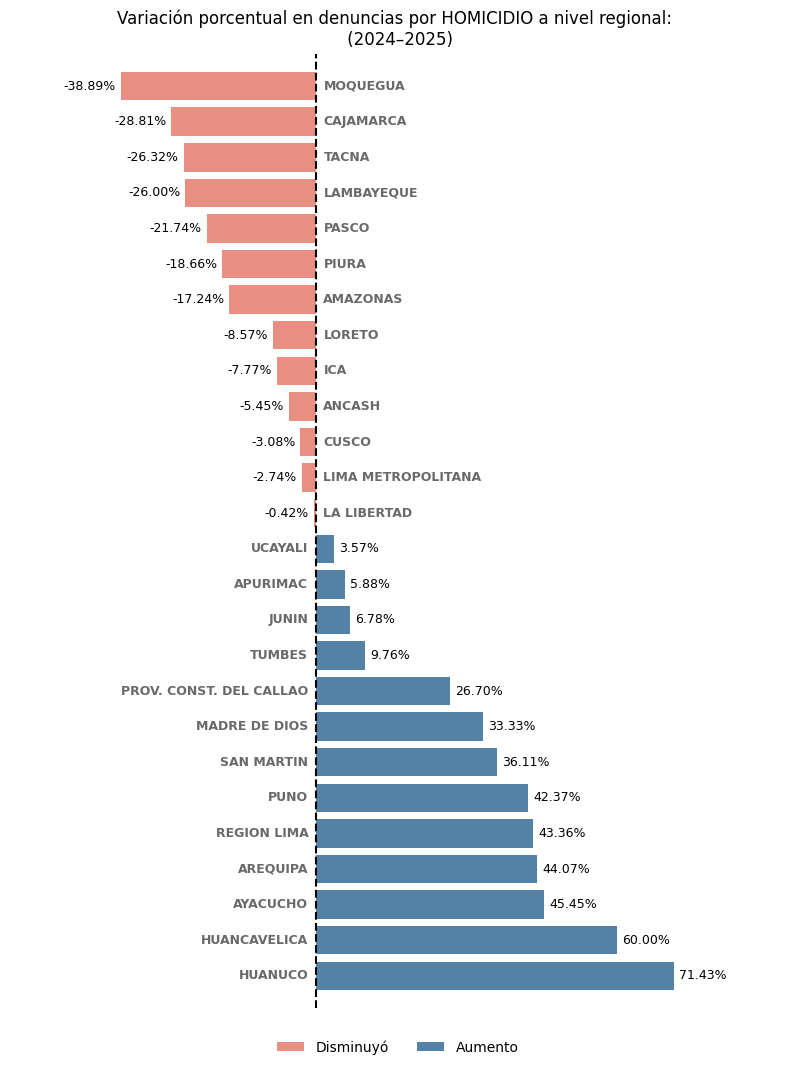

In [13]:
tabla_homicidio, img_homicidio = tabla_y_grafico_region("Homicidio", 2024, 2025)

Denuncias por HURTO a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,93801,78068,-16.77
1,LAMBAYEQUE,15975,15740,-1.47
2,AREQUIPA,14275,9370,-34.36
3,LA LIBERTAD,12699,8887,-30.02
4,PIURA,10325,7485,-27.51
5,ICA,6173,5739,-7.03
6,CUSCO,7057,4970,-29.57
7,JUNIN,7279,4512,-38.01
8,PROV. CONST. DEL CALLAO,5434,4253,-21.73
9,CAJAMARCA,5816,4108,-29.37


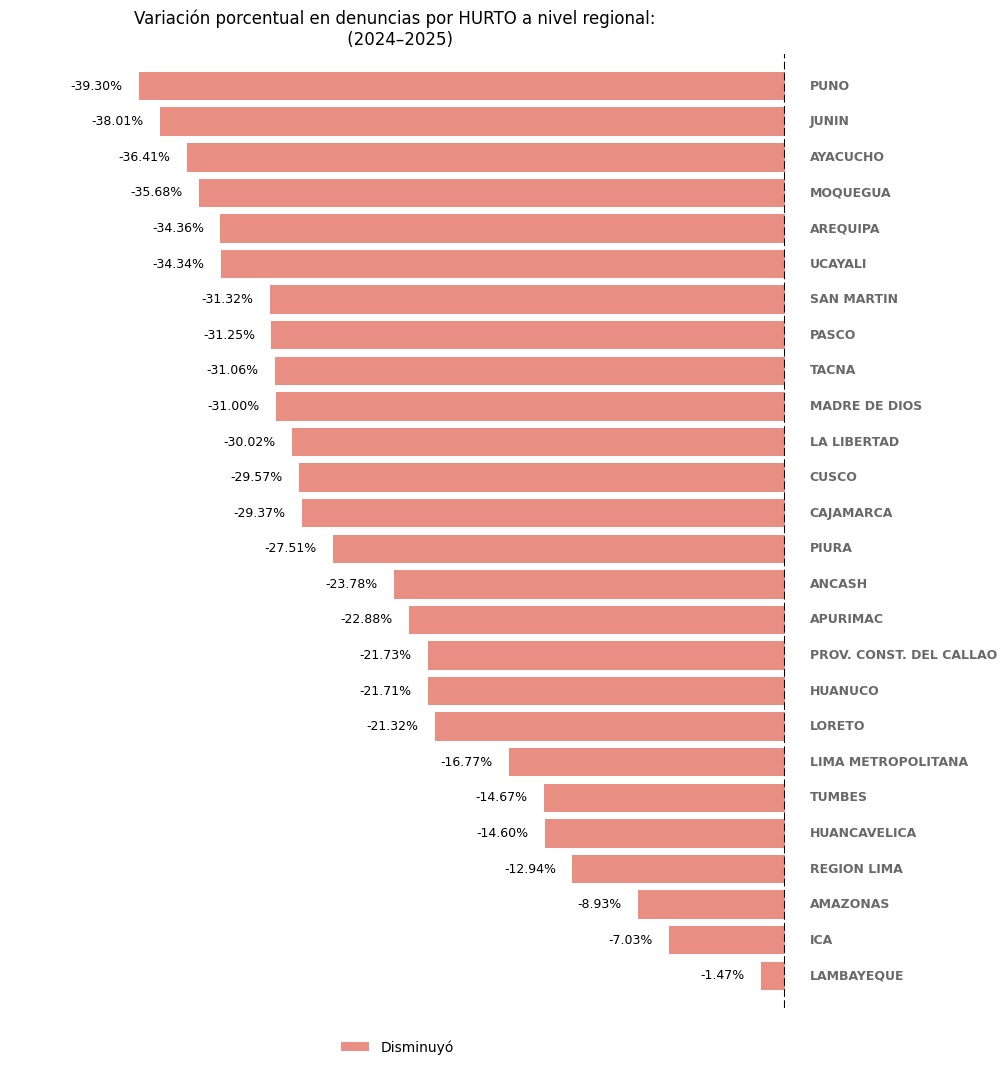

In [14]:
tabla_hurto, img_hurto = tabla_y_grafico_region("Hurto", 2024, 2025)

Denuncias por ROBO a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,55148,30920,-43.93
1,LAMBAYEQUE,6303,4640,-26.38
2,PIURA,7789,4451,-42.86
3,LA LIBERTAD,7537,3459,-54.11
4,ICA,3640,2720,-25.27
5,AREQUIPA,4688,2555,-45.50
6,REGION LIMA,3230,2308,-28.54
7,PROV. CONST. DEL CALLAO,4399,2093,-52.42
8,ANCASH,1801,1166,-35.26
9,CUSCO,1652,987,-40.25


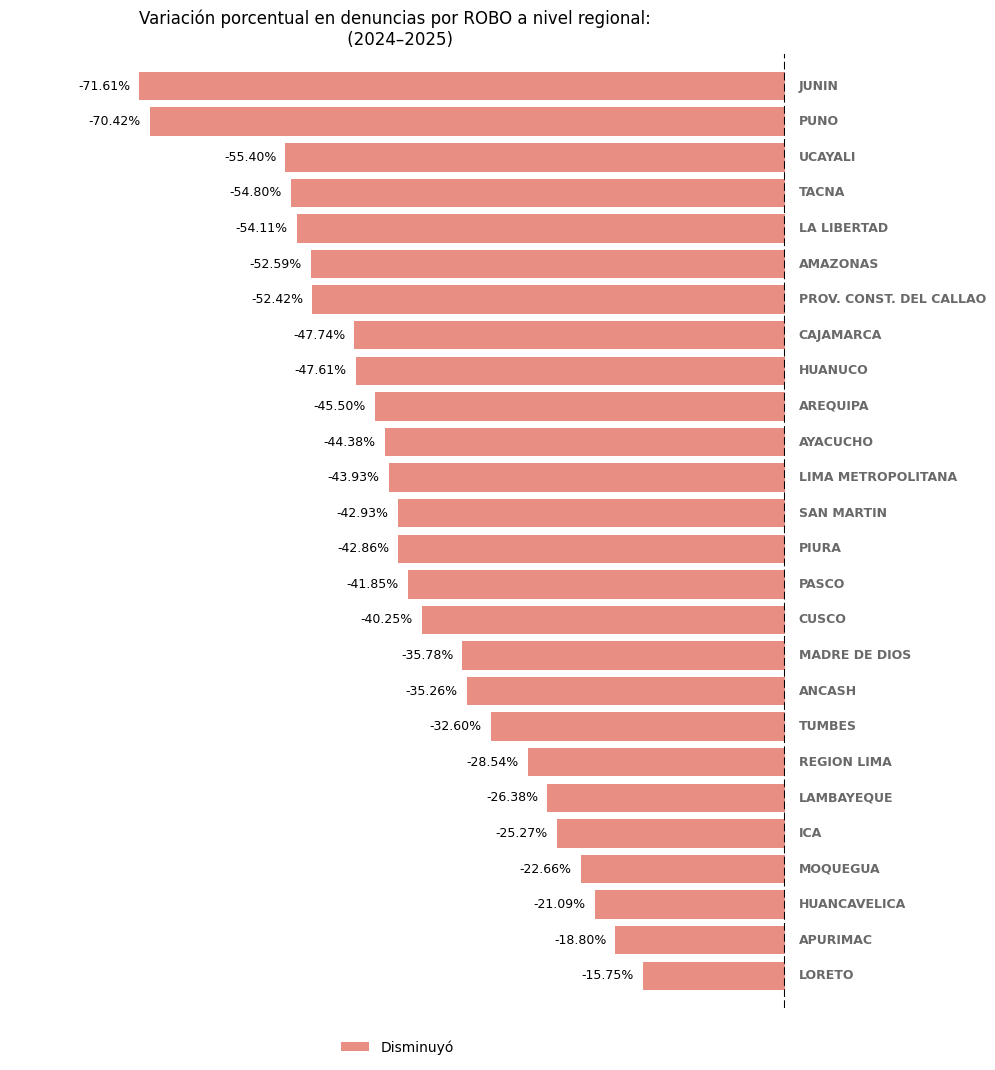

In [15]:
tabla_robo, img_robo = tabla_y_grafico_region("Robo", 2024, 2025)

Denuncias por SECUESTRO a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,583,552,-5.32
1,LA LIBERTAD,110,117,6.36
2,AREQUIPA,122,116,-4.92
3,ICA,60,63,5.00
4,LAMBAYEQUE,75,60,-20.00
5,REGION LIMA,65,57,-12.31
6,JUNIN,33,53,60.61
7,CAJAMARCA,57,52,-8.77
8,PROV. CONST. DEL CALLAO,55,47,-14.55
9,PUNO,34,46,35.29


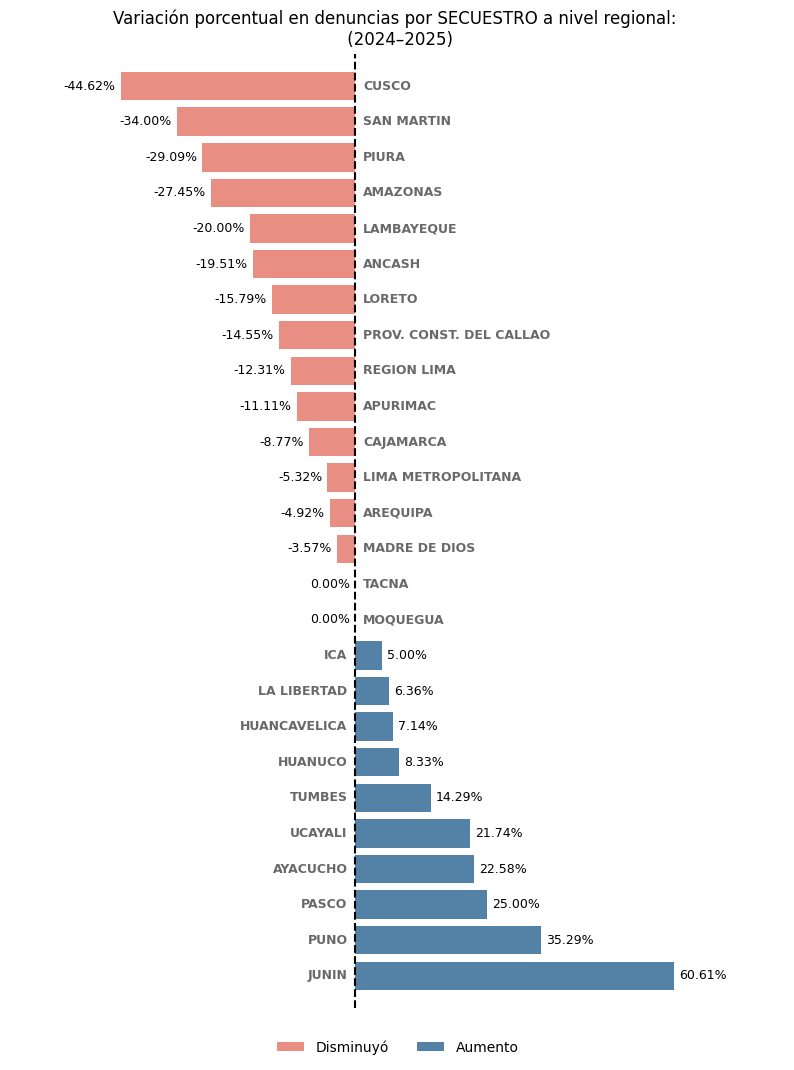

In [16]:
tabla_secuestro, img_secuestro = tabla_y_grafico_region("Secuestro", 2024, 2025)

Denuncias por VIOLACIÓN DE LA LIBERTAD SEXUAL a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,7758,7187,-7.36
1,AREQUIPA,1564,1315,-15.92
2,LAMBAYEQUE,1294,1145,-11.51
3,LA LIBERTAD,1413,1133,-19.82
4,JUNIN,1246,1107,-11.16
5,CUSCO,1195,1049,-12.22
6,PIURA,1251,992,-20.70
7,REGION LIMA,1006,867,-13.82
8,ICA,1079,865,-19.83
9,SAN MARTIN,1014,841,-17.06


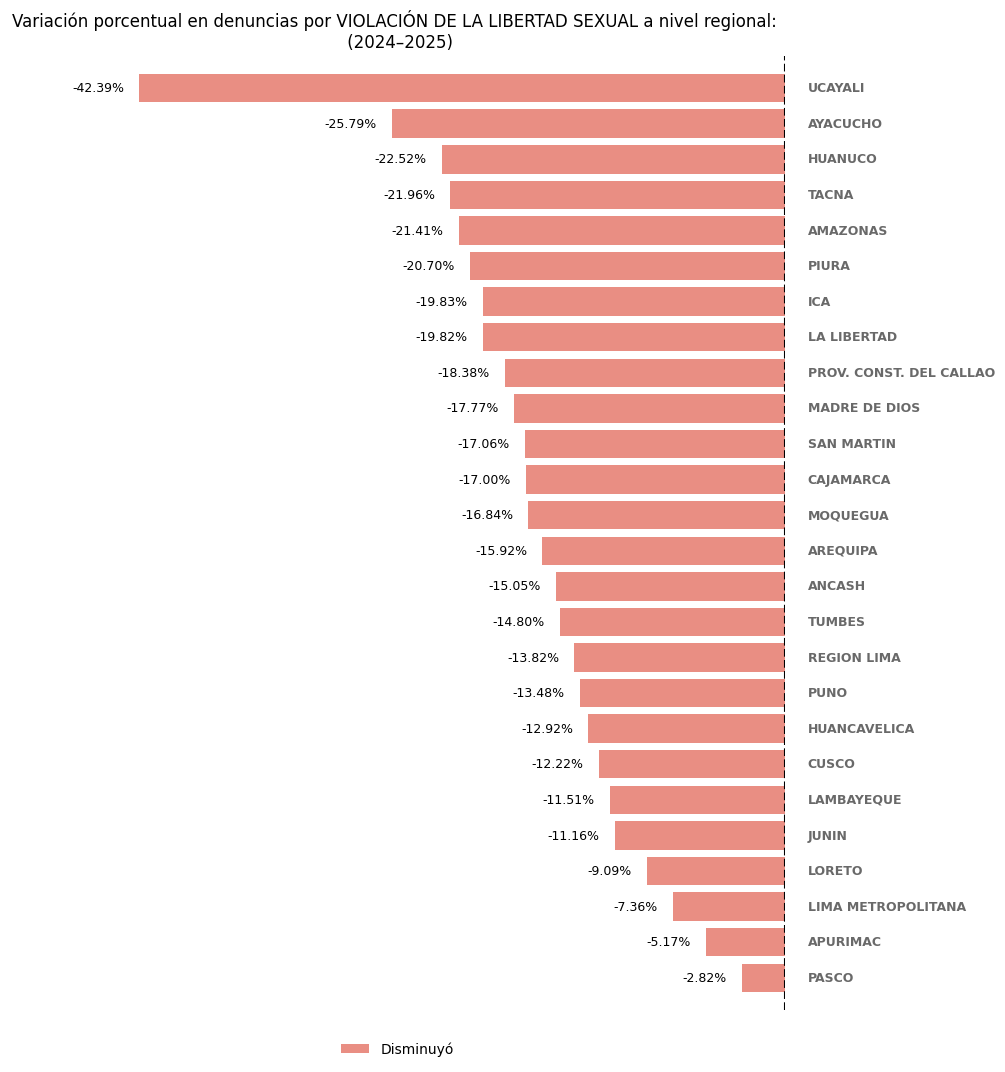

In [17]:
tabla_violacion, img_violacion = tabla_y_grafico_region(
    "Violación de la libertad sexual", 2024, 2025
)

Denuncias por OTROS a nivel regional: 2024-2025


AÑO,REGIÓN,2024,2025,VARIACIÓN %
0,LIMA METROPOLITANA,57086,57003,-0.15
1,LAMBAYEQUE,19575,18933,-3.28
2,LA LIBERTAD,13476,14889,10.49
3,AREQUIPA,14674,13659,-6.92
4,JUNIN,13452,11999,-10.80
5,CUSCO,10185,9281,-8.88
6,PIURA,10918,9080,-16.83
7,ANCASH,8770,8833,0.72
8,REGION LIMA,6876,8081,17.52
9,PROV. CONST. DEL CALLAO,8220,7420,-9.73


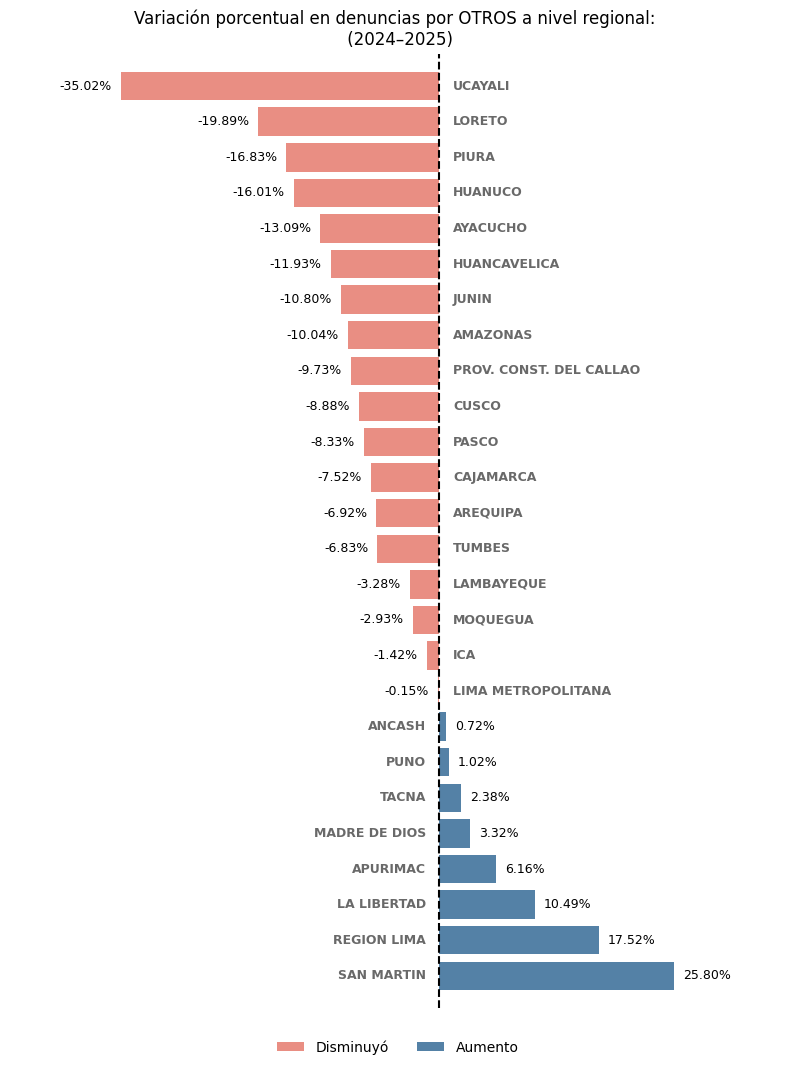

In [18]:
tabla_otros, img_otros = tabla_y_grafico_region("Otros", 2024, 2025)

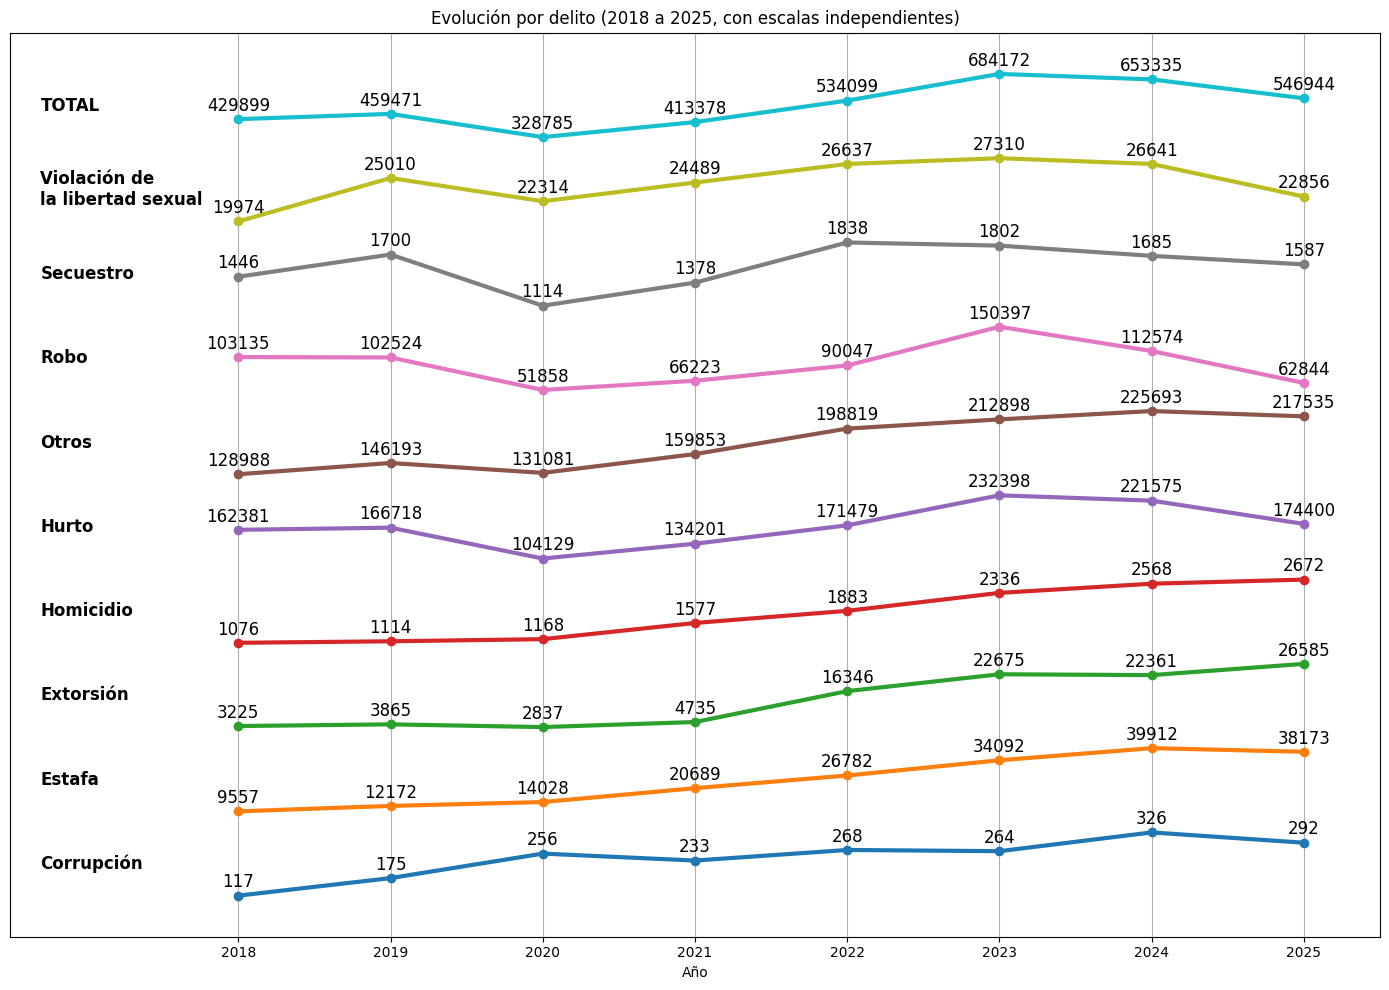

In [19]:
# Copiamos el DataFrame para no modificar el original
df = TABLA_POR_MODALIDAD.copy()

# Obtenemos la lista de años y delitos desde las columnas e índices del DataFrame
years = df.columns.astype(int).tolist()
delitos = df.index.tolist()

# Creamos la figura con tamaño ancho 14, alto 10 pulgadas
plt.figure(figsize=(14, 10))

# Definimos la altura de cada "banda" para una línea y el espacio entre bandas
band_height = 1.5
gap = 0.5


# Función para normalizar valores entre 0 y 1 para cada delito individualmente
def normalizar(valores):
    min_v, max_v = valores.min(), valores.max()
    if max_v != min_v:
        return (valores - min_v) / (max_v - min_v)
    else:
        # En caso de que todos los valores sean iguales, devolver ceros para evitar división por cero
        return np.zeros_like(valores)


# Función para insertar un salto de línea en el nombre del delito si es muy largo,
# para que la etiqueta no quede demasiado ancha y se vea mejor
def dividir_nombre(nombre, max_largo=25):
    if len(nombre) <= max_largo:
        return nombre
    partes = nombre.split()
    mitad = len(partes) // 2
    # Divide el nombre en dos partes y las junta con un salto de línea
    return " ".join(partes[:mitad]) + "\n" + " ".join(partes[mitad:])


# Ajustamos el margen izquierdo del gráfico para dejar espacio a las etiquetas de los delitos
plt.subplots_adjust(left=0.3)

# Dibujamos una línea para cada delito
for i, delito in enumerate(delitos):
    valores_reales = df.loc[delito].values  # Extraemos las denuncias reales del delito
    valores_norm = normalizar(valores_reales)  # Normalizamos para escalar entre 0 y 1

    # Calculamos la base vertical donde se ubicará esta línea, separada con band_height + gap
    base_y = i * (band_height + gap)

    # Elevamos los valores normalizados para que queden dentro de la banda asignada
    y_vals = base_y + valores_norm * band_height

    # Graficamos la línea con puntos
    plt.plot(years, y_vals, marker="o", linewidth=3)

    # Preparamos la etiqueta del delito con posible salto de línea
    delito_etiqueta = dividir_nombre(delito)

    # Colocamos la etiqueta a la izquierda de la línea, centrada verticalmente en la banda
    plt.text(
        min(years) - 1.3,
        base_y + band_height / 2,
        delito_etiqueta,
        ha="left",
        va="center",
        fontsize=12,
        fontweight="bold",
    )

    # Colocamos la cantidad de denuncias en cada punto de la línea, arriba un poco
    for x, y, real in zip(years, y_vals, valores_reales):
        plt.text(
            x, y + 0.1, str(real), ha="center", va="bottom", fontsize=12, rotation=0
        )

# Creamos un padding horizontal interno para que las líneas no peguen en los bordes del gráfico
padding_x = 0.5
plt.xlim(min(years) - 1.5, max(years) + 0.5)

# Ajustamos las marcas del eje X para que sean los años
plt.xticks(years)

# Ocultamos las marcas del eje Y porque las líneas están separadas y tienen etiquetas fuera
plt.yticks([])

# Etiqueta del eje X
plt.xlabel("Año")

# Título del gráfico
plt.title("Evolución por delito (2018 a 2025, con escalas independientes)")

# Dibujamos la cuadrícula solo en el eje X para facilitar lectura
plt.grid(axis="x")

# Ajuste automático del layout para evitar que se corten elementos
plt.tight_layout()

# Guardar figura para Excel (Buffer)
img_evolucion_delito = io.BytesIO()
plt.savefig(img_evolucion_delito, format="png", bbox_inches="tight")
img_evolucion_delito.seek(0)
# plt.close(fig)


# Mostrar el gráfico
plt.show()

In [20]:
def plot_delito(df, delito, ax):

    TABLA_DATO = pd.pivot_table(
        df,
        index=["AÑO", "MODALIDAD"],
        values="CANTIDAD",
        aggfunc="sum",
    ).reset_index()

    df_tipo_delito = TABLA_DATO[TABLA_DATO["MODALIDAD"] == delito]

    sns.lineplot(
        data=df_tipo_delito, x="AÑO", y="CANTIDAD", linewidth=2, marker="o", ax=ax
    )

    # Agregar cantidad encima de cada punto
    for x, y in zip(df_tipo_delito["AÑO"], df_tipo_delito["CANTIDAD"]):
        ax.text(
            x,
            y + max(df_tipo_delito["CANTIDAD"]) * 0.02,  # Desplaza un poco hacia arriba
            f"{y}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=10,
        )

    ax.margins(x=0.05, y=0.5)
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(f"{delito}")

    # Quitar líneas internas del gráfico
    ax.grid(False)

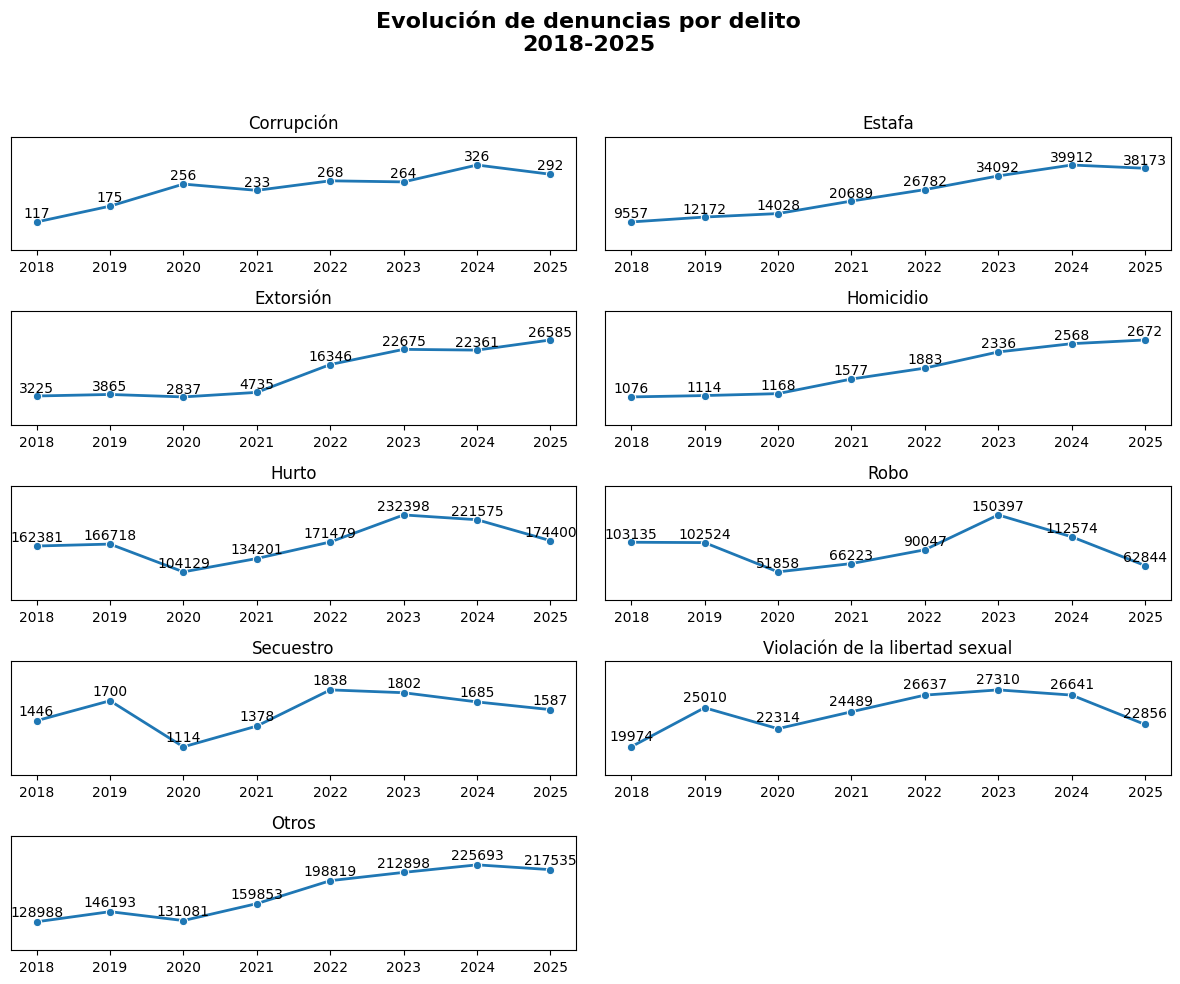

In [21]:
# Crear figura y ejes para 9 gráficos en fila
fig, axs = plt.subplots(5, 2, figsize=(12, 10))
axs = axs.flatten()


plot_delito(df_SIDPOL, "Corrupción", axs[0])
plot_delito(df_SIDPOL, "Estafa", axs[1])
plot_delito(df_SIDPOL, "Extorsión", axs[2])
plot_delito(df_SIDPOL, "Homicidio", axs[3])
plot_delito(df_SIDPOL, "Hurto", axs[4])
plot_delito(df_SIDPOL, "Robo", axs[5])
plot_delito(df_SIDPOL, "Secuestro", axs[6])
plot_delito(df_SIDPOL, "Violación de la libertad sexual", axs[7])
plot_delito(df_SIDPOL, "Otros", axs[8])
# Ocultar el último eje sobrante
axs[9].set_visible(False)

plt.suptitle(
    "Evolución de denuncias por delito\n2018-2025", fontsize=16, fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # dejar espacio para el título superior

# Guardar figura para Excel (Buffer)
img_2018_2025 = io.BytesIO()
fig.savefig(img_2018_2025, format="png")
img_2018_2025.seek(0)
# plt.close(fig)

plt.show()

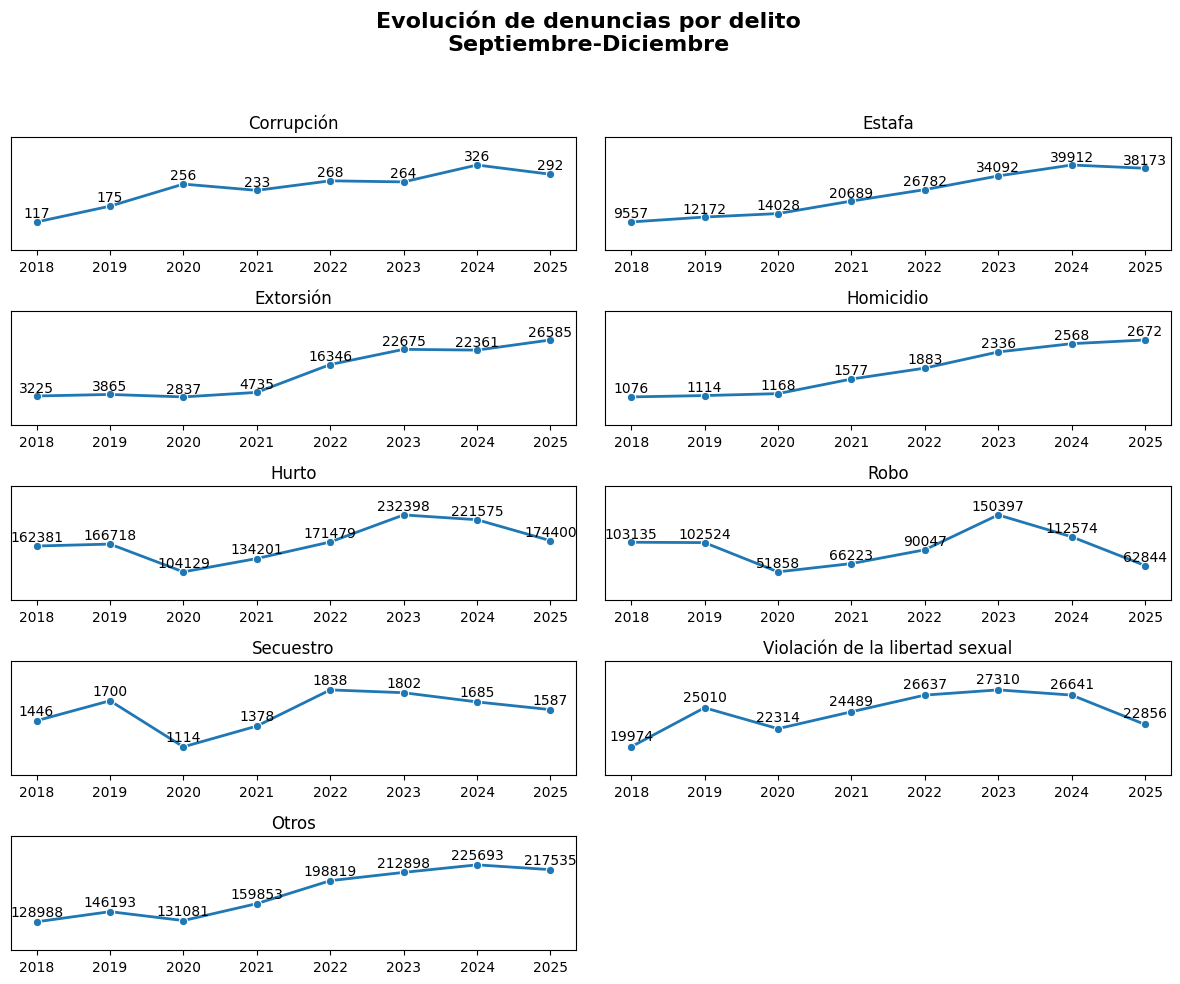

In [22]:
# Crear figura y ejes para 9 gráficos en fila
fig, axs = plt.subplots(5, 2, figsize=(12, 10))
axs = axs.flatten()


plot_delito(df_SIDPOL, "Corrupción", axs[0])
plot_delito(df_SIDPOL, "Estafa", axs[1])
plot_delito(df_SIDPOL, "Extorsión", axs[2])
plot_delito(df_SIDPOL, "Homicidio", axs[3])
plot_delito(df_SIDPOL, "Hurto", axs[4])
plot_delito(df_SIDPOL, "Robo", axs[5])
plot_delito(df_SIDPOL, "Secuestro", axs[6])
plot_delito(df_SIDPOL, "Violación de la libertad sexual", axs[7])
plot_delito(df_SIDPOL, "Otros", axs[8])
# Ocultar el último eje sobrante
axs[9].set_visible(False)

plt.suptitle(
    "Evolución de denuncias por delito\nSeptiembre-Diciembre",
    fontsize=16,
    fontweight="bold",
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # dejar espacio para el título superior

# Guardar figura para Excel (Buffer)
img_Sep_Dic = io.BytesIO()
fig.savefig(img_Sep_Dic, format="png")
img_Sep_Dic.seek(0)
# plt.close(fig)

plt.show()

In [23]:
# === GUARDAR EN EXCEL USANDO XLSXWRITER ===
nombre_del_archivo = "reporte_sidpol.xlsx"
hoja1 = "Reporte_Delitos"
hoja2 = "Reporte_Delitos_Sep_Dic"
hoja3 = "Grafico_Total_Delitos"
# hoja4 = 'Grafico Estafa'


lista_delitos = [
    ("Corrupción", tabla_corrupcion, img_corrupcion),
    ("Estafa", tabla_estafa, img_estafa),
    ("Extorsión", tabla_extorsion, img_extorsion),
    ("Homicidio", tabla_homicidio, img_homicidio),
    ("Hurto", tabla_hurto, img_hurto),
    ("Otros", tabla_otros, img_otros),
    ("Robo", tabla_robo, img_robo),
    ("Secuestro", tabla_secuestro, img_secuestro),
    # Acortamos el nombre para que entre en la pestaña de Excel (Max 31 caracteres)
    ("Violación", tabla_violacion, img_violacion),
]

with pd.ExcelWriter(nombre_del_archivo, engine="xlsxwriter") as writer:
    libro_excel = writer.book
    # Formato con separador de miles
    formato_miles = libro_excel.add_format({"num_format": "#,##0"})
    ### NUEVO: Crear un formato que solo contenga la definición del borde ###
    # El '1' corresponde a un borde delgado y continuo.
    formato_borde = libro_excel.add_format({"border": 1})

    # ---------------------------------------------------------
    # REPORTE DELITOS - HOJA 1
    # ---------------------------------------------------------

    # Convertir encabezados a texto para evitar formato de número en títulos
    TABLA_POR_MODALIDAD.columns = TABLA_POR_MODALIDAD.columns.astype(str)
    TABLA_POR_MODALIDAD.to_excel(writer, sheet_name=hoja1)

    excel_hoja1 = writer.sheets[hoja1]
    # Obtener las dimensiones del DataFrame (filas, columnas)
    (num_filas, num_columnas) = TABLA_POR_MODALIDAD.shape

    # Aplicar el formato condicional a excel_hoja1.
    excel_hoja1.conditional_format(
        0,
        0,
        num_filas,
        num_columnas,
        {
            "type": "no_blanks",  # No aplicar a celdas en blanco dentro del rango
            "format": formato_borde,
        },
    )

    excel_hoja1.set_column("A:A", 28)
    excel_hoja1.set_column("B:I", 10, formato_miles)
    excel_hoja1.hide_gridlines(2)  # Ocultar lineas de la hoja

    # Insertar imagen desde img_2018_2025 en la celda A14
    img_2018_2025.seek(0)
    excel_hoja1.insert_image(
        "A14",
        "grafico_total.png",
        {
            "image_data": img_2018_2025,
            "x_scale": 0.7,  # Reduce al 70% el ancho
            "y_scale": 0.7,  # Reduce al 70% el alto
        },
    )

    # ---------------------------------------------------------
    # REPORTE DELITOS SEP A DIC- HOJA 2
    # ---------------------------------------------------------

    # 1. Convertir encabezados a texto
    TABLA_SEP_DIC.columns = TABLA_SEP_DIC.columns.astype(str)
    TABLA_SEP_DIC.to_excel(writer, sheet_name=hoja2)
    excel_hoja2 = writer.sheets[hoja2]
    # Obtener las dimensiones del DataFrame (filas, columnas)
    (num_filas, num_columnas) = TABLA_SEP_DIC.shape

    # Aplicar el formato condicional a excel_hoja2.
    excel_hoja2.conditional_format(
        0,
        0,
        num_filas,
        num_columnas,
        {
            "type": "no_blanks",  # No aplicar a celdas en blanco dentro del rango
            "format": formato_borde,
        },
    )

    excel_hoja2.set_column("A:A", 28)
    excel_hoja2.set_column("B:I", 10, formato_miles)
    excel_hoja2.hide_gridlines(2)  # Ocultar lineas de la hoja

    # Insertar imagen desde img_Setiembre_Diciembre en la celda A14
    img_Sep_Dic.seek(0)
    excel_hoja2.insert_image(
        "A14",
        "grafico_sep_dic.png",
        {
            "image_data": img_Sep_Dic,
            "x_scale": 0.7,  # Reduce al 70% el ancho
            "y_scale": 0.7,  # Reduce al 70% el alto
        },
    )

    # ---------------------------------------------------------
    # GRAFICO DE EVOLUCION DE DELITOS 2018 A 2025 - HOJA 3
    # ---------------------------------------------------------

    libro_excel = writer.book
    excel_hoja3 = libro_excel.add_worksheet(hoja3)
    excel_hoja3.hide_gridlines(2)  # Ocultar lineas de la hoja

    img_evolucion_delito.seek(0)
    excel_hoja3.insert_image(
        "A1",
        "grafico_evolucion.png",
        {
            "image_data": img_evolucion_delito,
            "x_scale": 0.7,  # Reduce al 70% el ancho
            "y_scale": 0.7,  # Reduce al 70% el alto
        },
    )

    # ---------------------------------------------------------
    # BUCLE AUTOMÁTICO PARA EL RESTO DE HOJAS
    # ---------------------------------------------------------
    for nombre_delito, tabla, imagen in lista_delitos:
        # Validación de seguridad: Si la tabla está vacía, saltamos al siguiente
        if tabla is None or imagen is None:
            continue

        # Definir nombre de la hoja (Max 31 caracteres en Excel)
        # Ejemplo: "Grafico Estafa", "Grafico Robo"
        nombre_hoja = f"Grafico {nombre_delito}"[:31]

        # 1. Convertir encabezados a texto
        tabla.columns = tabla.columns.astype(str)

        # 2. Exportar a Excel
        tabla.to_excel(
            writer, sheet_name=nombre_hoja, index=False
        )  # index=True por defecto (Región en A)

        # 3. Obtener el objeto hoja
        hoja_actual = writer.sheets[nombre_hoja]
        (num_filas, num_columnas) = tabla.shape

        # 4. Formato Condicional (Bordes)
        hoja_actual.conditional_format(
            0,
            0,
            num_filas,
            num_columnas - 1,
            {"type": "no_blanks", "format": formato_borde},
        )

        # 5. Anchos de Columna
        # A: Región, B-C: Años, D: Variación
        hoja_actual.set_column("A:A", 25)
        hoja_actual.set_column("B:C", 12, formato_miles)  # Años con separador de miles
        hoja_actual.set_column("D:D", 12)

        hoja_actual.hide_gridlines(2)

        # 6. Insertar Imagen
        imagen.seek(0)  # Asegurar que leemos la imagen desde el principio

        # Insertamos en la fila 30 (A30)
        hoja_actual.insert_image(
            "F1",
            f"img_{nombre_delito}.png",
            {"image_data": imagen, "x_scale": 0.7, "y_scale": 0.7},
        )

        print(f"Hoja '{nombre_hoja}' generada.")

print(
    f"\nReporte SIDPOL - Delitos de 2018-2025 '{nombre_del_archivo}' generado correctamente."
)

Hoja 'Grafico Corrupción' generada.
Hoja 'Grafico Estafa' generada.
Hoja 'Grafico Extorsión' generada.
Hoja 'Grafico Homicidio' generada.
Hoja 'Grafico Hurto' generada.
Hoja 'Grafico Otros' generada.
Hoja 'Grafico Robo' generada.
Hoja 'Grafico Secuestro' generada.
Hoja 'Grafico Violación' generada.

Reporte SIDPOL - Delitos de 2018-2025 'reporte_sidpol.xlsx' generado correctamente.
